<a href="https://colab.research.google.com/github/pattangeumdduck/HRI_monitoring_system/blob/main/aice_professionalstudy8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#텐서플로 이미지 처리 프레임워크
- 이미지 데이터 확보 : 본인 소유 사진, 오픈 이미지 데이터 , MS-COCO, PASCAL VOC, Google Open Images, A- hub 등
- 이미지 데이터 읽기 : PIL, Tensorflow ,CV2
- 이미지 데이터 전처리 : 수많은 이미지를 한번어 처리하기 어려움: 파이프라인 : Dataset 생성, Shuffle, Batch, 사이즈 조절
- 이미지 모델링 : 이미지 분류 :DNN /CNN /RNN, 객체 탐지 : Yolo, RCNN, SDD

<오픈 이미지 데이터>
Tensorflow 오픈 데이터셋 :https://www.tensorflow.org/datasets
MS-COCO 데이터셋 : http;//cocodataset.org/#download
PASCAL VOC 데이터셋 : http://host.robots.ox.ac.uk/pascal/VOC/voc2012/
Google Open Image: https://storage.googleapis.com/openimages/web/index.html

<이미지 데이터 읽는법>
PIL
from PIL import image
Image = image.open('dog.jpg')
plt.imshow(image)

Tensorflow
import tensorflow as tf
Image = tf.io.read_file('dog.jpg')
image = tf.image.decode_image(image)
plt.imshow(image)

CV2
import cv2
image = cv.imread('dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#이미지 데이터 전처리
#딥러닝에서 이미지 처리 순서
- 이미지를 읽어 메모리 로드
- 이미지들을 Shuffle
- 한번에 처리할 batch 크기로 이미지 나누기
- 파이프라인 :Dataset -> Shuffle -> Batch -> chche ->prefetch (한번에 처리할 수 있게 만들어줌)
->데이터 읽고,배치사이즈로 섞고 나누고, Prefetch등 함수 제공
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(1000).batch(16).cache().prefetch()

-필요시 이미지 증강 처리 : 모델 성능 높이기 위해(resize, flip)
image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
image = tf.image.flip_left_right(image)

이미지 모델링
- 이미지 분류 DNN,CNN,RNN
- 객체 탐지 : Yolo, RCNN, SDD

#Dataset_from_tensor_slices 이용하여 입력 파이프라인 구축
- 이미지 처리하려고 하면 이미지 읽어오기, 이미지 섞기, 배치 사이즈로 나누기 등 굉장히 많은 일들이 있음.
- 일일히 이런 일들을 코딩해서 처리하려면 굉장히 많ㅇ느 시간과 노력이 필요함
- tensorflow 의 Dataset 활용해서 Dataset Pipeline (이미지 읽기, 섞기 ,배치) 를 만들자
- 이미 고수준 API 만들어져 있으므로 , 이들을 잘 불러와서 활용할 줄 알면 됨

#목표 : 이미지 dataSet pipeline 사용해보기
1. MNIST 데이터를 from_tensor_slices 사용해 Dataset으로 읽어오기(단, from_tensor_ slices 는 메모리에 있는 데이터만을 읽어올 수 있다.)
2. Dataset 에 대해 전처리, 미니배치, 랜덤셔플링의 데이터 파이프라인을 사용해 전처리 완료된 데이터셋 만들기
3. 이미지 처리 위한 파이프라인 만들기
4. 만든 Dataset에서 샘플 데이터 가져오기
5. DNN 모델 만들고 학습하기



In [1]:
# import necessory libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#mnist 데이터 메모리로 가져오기

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 , x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print("The shape of train dataset:", x_train.shape)
print("The shape of test dataset :", x_test.shape)

The shape of train dataset: (60000, 28, 28)
The shape of test dataset : (10000, 28, 28)


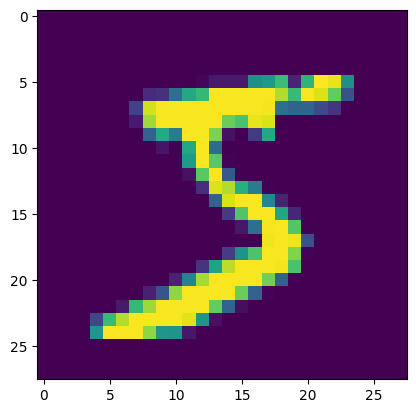

In [4]:
# x_train 첫 번째 이미지 확인하기
plt.imshow(x_train[0])

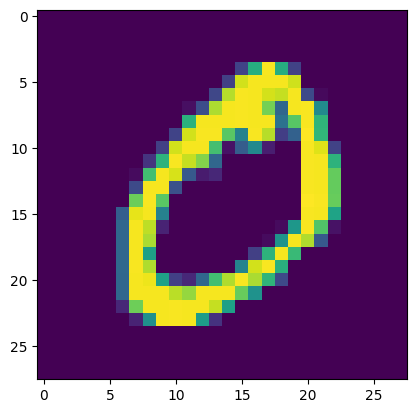

In [5]:
# x_train 두 번쨰 이미지 확인하기
plt.imshow(x_train[1])

In [8]:
# Add a channels dimension . 이미지 사이즈로 만들어 줌. 원래 이미지는 Height * Width * Channel 3차원으로 구성됨 -> 채널을 하나 새로 만들어줌
# x_train.reshape(-1,28,28,1)으로 사용해도 된다.

x_train = x_train[..., tf.newaxis] #새 축(채널) 을 하나 더 만들어줬음
x_test = x_test[ ... , tf.newaxis]

print("The shape of train dataset :", x_train.shape)
print("The shape of test dataset : ", x_test.shape)

The shape of train dataset : (60000, 28, 28, 1, 1, 1)
The shape of test dataset :  (10000, 28, 28, 1, 1, 1)


#이미지 처리를 위한 파이프라인 만들기
- from_tensor_slices :입력맏기
- shuffle
- batch
- cahce(데이터 일부를 캐시메모리에 저장할 수 있도록 함)
- prefetch(모델이 s번째 데이터를 읽는 동안, s+1번째 데이터를 준비)

In [9]:
#파이프라인 구성
AUTOTUNE = tf.data.experimental.AUTOTUNE  #병렬로 알아서 처리해서 써라라는 뜻

#train dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) #여러개 입력시 튜플로 입력할것, 입력 받는 부분
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(AUTOTUNE) #미리 준비할 수 있게끔 프리패치까지 적용

#test dataset: shuffle이 필요하진 않음
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(AUTOTUNE)


In [10]:
#만든 Dataset에서 샘플 가져오기
# Train 데이터셋 확인
# (None, 28, 28, 1), (None, ) 2개의 값으로 구성됨
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1, 1, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [11]:
#iter , next 통해서 샘플 데이터 가져오기
x_train_sample, y_train_sample = next(iter(train_ds))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


TypeError: Invalid shape (28, 28, 1, 1, 1) for image data

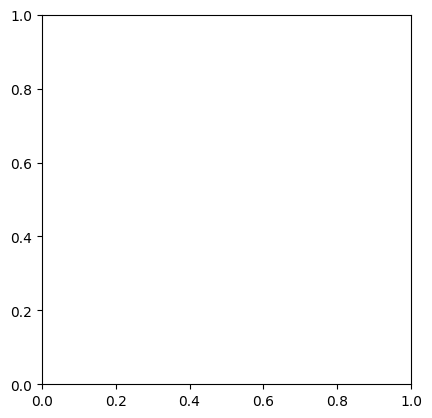

In [13]:
#가죠온 1개 샘플데이터에 대한 shape 확인
#첫 번쨰 샘플은 1개의 batch 로 32개 이미지 구성됨
#두 번째 샘플은 32개의 label로 구성
print(type(x_train_sample), type(y_train_sample ))
#가져온 첫 번째 샘플이미지 확인
plt.imshow(x_train_sample[0])

In [15]:
#DNN 모델 만들고 학습하기
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = [tf.keras.metrics.sparse_categorical_accuracy])

history = model.fit(train_ds, epochs = 5, batch_size = 32, validation_data = (test_ds))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.1741 - val_sparse_categorical_accuracy: 0.9486
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.1291 - val_sparse_categorical_accuracy: 0.9611
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.1155 - val_sparse_categorical_accuracy: 0.9653
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0848 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.1096 - val_sparse_categorical_accuracy: 0.9661
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.1062 - val_sparse_categorical_accuracy: 0.9679


In [16]:
#모델 평가
#모델 평가시 입력 데이터를 x_test, y _test 이런식으로 들어가는데, 우리는 데이터셋을 만들어서 그냥 데이터셋을 넣어 주면 됨
model.evaluate(test_ds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9643


[0.10622461140155792, 0.9678999781608582]

#배운 내용 정리
1. 이미지 dataset pipeline 만들어봄
2. from_tensorslices 함수 이용해 필요한 데이터를 Dataset으로 읽어와
3. 읽어온 데이터를 파이프라인을 통하여 shuffle,batch, cache, prefetch 된 Dataset을 만들 수 있다.
4.외우지 못해도 이런 식으로 사용할 수 있다는 것을 알고 필요할떄 사용하면 좋음.